# Density calculations
This notebook loads the data extracted from the literature and integrate it into density estimate for the number of cells per cell type in a gram of tissue

In [7]:
import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import colors
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import scipy.stats as stats
from scipy.stats import gmean, norm, lognorm, sem

## Myeloid cells - Macrophages, Monocytes and Dendritic cells

First we load the macrophages and deal with them

In [8]:
data_dir = "Data/Literature data"
res_dir = "Data/Interim results"

In [9]:
fname = 'density_data.xlsx'
f_path = f"{data_dir}/{fname}"
macro_dens = pd.read_excel(f_path, sheet_name='Myeloid_cells')
macro_dens.loc[macro_dens.subtissue.isnull(), 'subtissue'] = '-'
macro_cell_types = ['Macrophage', 'Microglia', 'Langerhans', 'Kupffer']
other_cell_types = ['Monocyte', 'Dendritic cells']
def which_cell_type(c):
    for mct in macro_cell_types:
        if c.upper().find(mct.upper())>=0:
            return 'Macrophage'
    for mct in other_cell_types:
        if c.upper().find(mct.upper())>=0:
            return mct

macro_dens['cell_type_'] = macro_dens.cell_type.map(which_cell_type)

In [10]:
macro_dens[macro_dens.cell_type_ == 'Macrophage'].head(2)

Source             cell_type tissue   subtissue location specie  \
0         Gates 1961         Kupffer cells  Liver           -      NaN  human   
1  Stone et al. 1992  Alveolar macrophages  Lungs  Parenchyma      NaN  human   

                      population     method  original area [mu^2]  \
0  healthy tissues from patients  histology                   NaN   
1  healthy tissues from patients  histology                   NaN   

   thickness [mu]  ...  anchor_density  anchor_density_sem  \
0             NaN  ...             NaN                 NaN   
1             NaN  ...             NaN                 NaN   

   total_target_cells  total_target_cells_sem  relevant_tissue_volume  \
0                 NaN                     NaN                     NaN   
1        1.200000e+10            4.000000e+09                   500.0   

   relevant_tissue_volume_sem  target_cells_density_per_g  \
0                         NaN                    20000000   
1                       100.0                    24000000   

   target_cells_density_sem  \
0                    500000   
1                   9000000   

                                             comment  cell_type_  
0  The same derivation we did in Sender & Milo 20...  Macrophage  
1   total volume of 8.2 cm^3 in alveolar macrophages  Macrophage  

[2 rows x 26 columns]

Functions for transforming the uncertinaty to log space to be dealt as longormal distribution

In [11]:
def gmean_w_nulls(arr):
    return np.exp(np.mean(np.log(arr)))


def mult_unc_for_arr(arr):
    non_nans = np.sum(1 - np.isnan(arr))
    if non_nans == 0:
        return np.nan
    elif non_nans == 1:
        return 1
    else:
        return np.exp((np.log(arr)).sem())


def err_add_to_mul(val_arr, err_arr):
    return ((val_arr + err_arr) / (val_arr - err_arr)) ** 0.5


def unc_fac_cal(
    val_arr,
    err_arr,
    err_additive=False,
):
    means_var_fac = mult_unc_for_arr(val_arr)
    if err_additive:
        sems_var_fac = gmean_w_nulls(err_add_to_mul(val_arr, err_arr))
    else:
        sems_var_fac = gmean_w_nulls(err_arr)
    # print(means_var_fac, sems_var_fac)
    return np.exp(
        np.sqrt(np.square(np.log(means_var_fac)) + np.square(np.log(sems_var_fac)))
    )

The next function is using fit to lognormal distribution for estimating the the error as an multiplication uncertinaty

In [12]:
def mul_err_equiv(
    val,
    lin_err,
    n=1000,
):
    if np.isnan(lin_err):
        if np.isnan(val):
            return np.nan, np.nan
        else:
            return val, 1
    rvs = norm(val, lin_err).rvs(n)
    params = lognorm.fit(rvs[rvs > 0], floc=0)
    return params[2], np.exp(params[0])

In [13]:
macro_dens = macro_dens.join(
    macro_dens.apply(
        lambda row: pd.Series(
            mul_err_equiv(row.target_cells_density_per_g, row.target_cells_density_sem),
            index=["density", "err"],
        ),
        axis=1,
    )
)

Using pivot table and groupby for aggregating the estimates and the uncertinaties

In [14]:
mac_dens_piv = macro_dens[macro_dens.cell_type_ == "Macrophage"].pivot_table(
    index=["tissue", "subtissue"],
    columns=["specie"],
    values="density",
    aggfunc=gmean_w_nulls,
)
density_errors = (
    macro_dens[macro_dens.cell_type_ == "Macrophage"]
    .groupby(["tissue", "subtissue", "specie"])
    .apply(lambda row: unc_fac_cal(val_arr=row.density, err_arr=row.err))
    .unstack("specie")
)
ind = pd.MultiIndex.from_product([mac_dens_piv.columns, ["density", "err"]])
mac_dens_piv = mac_dens_piv.join(
    density_errors,
    lsuffix="_density",
    rsuffix="_err",
)
# mac_dens_piv

In [16]:
tiss_df = pd.read_excel(f_path, sheet_name="Tissues")
tiss_df.subtissue = tiss_df.subtissue.fillna("-")
tiss_df.index = pd.MultiIndex.from_frame(tiss_df[["tissue", "subtissue"]])
tiss_df = tiss_df.join(mac_dens_piv)
tiss_df.loc[~tiss_df["front line organ"].isnull(), "groups"] = "front line epithelial"

The next functions are meant for the aggregation of different tissues / subtissues into an overall estimate. There is a difference between macrophages and other cell types due to the use of extrapolation from rodents for macrophages

In [17]:
def sumsq(arr):
    return np.sqrt(np.sum(arr**2))

tiss_df = tiss_df.reset_index(drop=True)


def agg_by_tissue(df):
    output = pd.Series(dtype=float)
    output["mass"] = df.man.sum()
    output["sem"] = sumsq(df["sem"]) * df.man.sum() / (df.mass.sum() if df.mass.sum()>0 else 1)
    if np.isnan(output["sem"]):
        output["sem"] = 0
    output["groups"] = df["groups"].iloc[0]
    output["for_final_table"] = df["for_final_table"].iloc[0]
    if "human_density" in df.columns:
        for spec in ["human", "mouse"]:
            sp_dens = "{}_density".format(spec)
            sp_err = "{}_err".format(spec)
            if df[sp_dens].isnull().all():
                output[sp_dens] = np.nan
                output[sp_err] = np.nan
            else:
                output[sp_dens] = np.average(df[sp_dens].fillna(0), weights=df.mass)
                output[sp_err] = df.loc[~df[sp_dens].isnull(), sp_err].values[0]
    else:
        sp_dens, sp_err = "density", "err"
        if df[sp_dens].isnull().all():
            output[sp_dens] = np.nan
            output[sp_err] = np.nan
        else:
            output[sp_dens] = np.average(df[sp_dens].fillna(0), weights=df.mass)
            output[sp_err] = df.loc[~df[sp_dens].isnull(), sp_err].values[0]
    return output


tiss_agg_df = tiss_df.groupby("tissue").apply(agg_by_tissue)

In [18]:
def error_linear_to_mul(val_arr, err_arr):
    return gmean([1 / (1 - err_arr / val_arr), 1 + err_arr / val_arr])


"""
arr - array 3xn with row for each value added. Each with mean, uncertainty type and uncertainty factor
"""


def unc_of_add(arr, n_iterations=1000):
    n_var = arr.shape[0]
    if n_var == 1:
        if arr[0, 1] == "linear":
            return error_linear_to_mul(arr[0, 0], arr[0, 2])
        else:
            return arr[0, 2]
    else:
        # print(arr)
        dists = [
            norm(arr[i, 0], arr[i, 2])
            if arr[i, 1] == "linear"
            else lognorm(scale=arr[i, 0], s=np.log(arr[i, 2]) + 0.0001)
            for i in range(arr.shape[0])
        ]
        x = np.zeros([n_iterations, n_var])
        for i in range(arr.shape[0]):
            dist = (
                norm(arr[i, 0], arr[i, 2])
                if arr[i, 1] == "linear"
                else lognorm(scale=arr[i, 0], s=np.log(arr[i, 2]) + 0.0001)
            )
            # print(dist.kwds)
            x[:, i] = dist.rvs(n_iterations)
        fit_params = lognorm.fit(x.sum(axis=1), floc=0)
        return np.exp(fit_params[0])


"""
Each column is uncertainty factors of another variable
"""


def unc_of_mul(unc_facs_arr):
    log_unc_facs = np.log(unc_facs_arr)
    return np.exp((log_unc_facs**2).sum(axis=1) ** 0.5)

In [19]:
save_dir = "Figures"
mpl.style.use("seaborn")
sns.set_style("whitegrid")

rc_pars = {
    "legend.facecolor": "white",
    "legend.framealpha": 0.85,
    "lines.linewidth": 3,
    "legend.edgecolor": "Black",
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.shadow": False,
    "figure.figsize": [10, 7],
    "figure.dpi": 300,
}

sns.set_context("talk", rc=rc_pars)

C:\Users\Ron Sender\AppData\Local\Temp\ipykernel_7516\141711981.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn")


Aggregating on the groups to get an mean density by type of tissues, for extrapolation to other tissues lacking measurements

In [20]:
groups_dens = tiss_agg_df.pivot_table(
    index="groups",
    values=["human_density"],
    aggfunc=gmean_w_nulls,
)
groups_dens["err"] = tiss_agg_df.groupby(["groups"]).apply(
    lambda row: unc_fac_cal(
        val_arr=row.human_density,
        err_arr=row.human_err,
        err_additive=False,
    )
)
# groups_dens

In [21]:
only_human = tiss_agg_df[["groups", "human_density", "human_err"]]
only_human.columns = ["groups", "density", "err"]
only_mouse = tiss_agg_df[["groups", "mouse_density", "mouse_err"]]
only_mouse.columns = ["groups", "density", "err"]
both = pd.concat([only_human, only_mouse], ignore_index=True)
groups_dens["both_density"] = both.pivot_table(
    index="groups",
    values="density",
    aggfunc=gmean_w_nulls,
)
groups_dens["both_err"] = both.groupby(["groups"]).apply(
    lambda row: unc_fac_cal(
        val_arr=row.density,
        err_arr=row.err,
        err_additive=False,
    )
)
# groups_dens

In [22]:
def which_method(row, using_mouse=False):
    if np.isnan(row.human_density):
        if using_mouse & ~np.isnan(row.mouse_density):
            return "mouse"
        else:
            return "extrapolation"
    else:
        return "human"


relevant_tissue_groups = [
    "marrow",
    "lymph system",
    "front line epithelial",
    "epithelial organ",
    "connective",
    "muscle fiber",
    "adipose tissue",
    "CNS",
]
tiss_agg_df = tiss_agg_df.loc[tiss_agg_df.groups.isin(relevant_tissue_groups)].copy()
tiss_agg_df["method_w_mouse"] = tiss_agg_df.apply(
    lambda row: which_method(row, using_mouse=True), axis=1
)
tiss_agg_df["method_no_mouse"] = tiss_agg_df.apply(
    lambda row: which_method(row, using_mouse=False), axis=1
)


def ext_density(row, using_mouse=False):
    method = row.method_w_mouse if using_mouse else row.method_no_mouse
    if method == "human":
        return row.human_density, row.human_err
    elif method == "mouse":
        return row.mouse_density, row.mouse_err
    else:
        if using_mouse:
            return groups_dens.loc[row.groups, ["both_density", "both_err"]].values
        else:
            return groups_dens.loc[row.groups, ["human_density", "err"]].values


temp = tiss_agg_df.apply(
    ext_density,
    axis=1,
    result_type="expand",
)
tiss_agg_df["ext_dens"], tiss_agg_df["ext_dens_err"] = temp[0], temp[1]
temp = tiss_agg_df.apply(
    lambda row: ext_density(row, using_mouse=True),
    axis=1,
    result_type="expand",
)
tiss_agg_df["ext_dens_wm"], tiss_agg_df["ext_dens_err_wm"] = temp[0], temp[1]


Using the geometric mean of the rodent extrpolation and the human extrapolation where human data is lacking

In [23]:
tiss_agg_df["density"] = tiss_agg_df.ext_dens
tiss_agg_df["err"] = tiss_agg_df.ext_dens_err
tiss_agg_df.loc[tiss_agg_df.method_w_mouse != "human", "density"] = tiss_agg_df.loc[
    tiss_agg_df.method_w_mouse != "human", ["ext_dens", "ext_dens_wm"]
].apply(gmean_w_nulls, axis=1)


def weight_err(vals, unc):
    # gm = gmean_w_nulls(vals)
    inter = sem(np.log(vals))
    intra = np.mean(np.log(unc))
    return np.exp(np.sqrt(inter**2 + intra**2))


tiss_agg_df.loc[tiss_agg_df.method_w_mouse != "human", "err"] = tiss_agg_df.loc[
    tiss_agg_df.method_w_mouse != "human"
].apply(
    lambda rw: weight_err(
        vals=[rw.ext_dens, rw.ext_dens_wm], unc=[rw.ext_dens_err, rw.ext_dens_err_wm]
    ),
    axis=1,
)
# tiss_agg_df

Multiplying by mass to get the overall number of cells estimate

In [24]:
tiss_agg_df["total_no_mouse"] = tiss_agg_df.ext_dens * tiss_agg_df.mass
tiss_agg_df["mass_unc"] = error_linear_to_mul(tiss_agg_df.mass, tiss_agg_df["sem"])
tiss_agg_df["err_no_mouse"] = unc_of_mul(tiss_agg_df[["mass_unc", "ext_dens_err"]])

tiss_agg_df["total_w_mouse"] = tiss_agg_df.ext_dens_wm * tiss_agg_df.mass
tiss_agg_df["err_w_mouse"] = unc_of_mul(tiss_agg_df[["mass_unc", "ext_dens_err_wm"]])
tiss_agg_df["total"] = tiss_agg_df.density * tiss_agg_df.mass
tiss_agg_df["total_err"] = unc_of_mul(tiss_agg_df[["mass_unc", "err"]])

def agg_tissue_group(df):
    # print(df.shape, df.groups.iloc[0])
    cols = ["total_no_mouse", "total_w_mouse", "total"]
    output = pd.Series(dtype=float, index=cols)
    output[cols] = df[cols].sum()
    df["unc_type"] = "mul"
    output["err_no_mouse"] = unc_of_add(
        df[["total_no_mouse", "unc_type", "err_no_mouse"]].values
    )
    output["err_w_mouse"] = unc_of_add(
        df[["total_w_mouse", "unc_type", "err_w_mouse"]].values
    )
    output["total_err"] = unc_of_add(df[["total", "unc_type", "total_err"]].values)

    # print(output)
    return output


# tiss_agg_df.groupby("groups").apply(agg_tissue_group)

For the final table we wish to use a slightly different division into groups/systems

In [25]:
summ = tiss_agg_df.groupby("for_final_table").apply(agg_tissue_group)
group_order = [
    "Bone Marrow",
    "Lymph system",
    "Liver",
    "GI",
    "Lungs",
    "Skin",
    "Others",
]
summ = summ.loc[group_order]
summ.loc["Total"] = agg_tissue_group(summ)
summ

total_no_mouse  total_w_mouse         total  err_no_mouse  \
for_final_table                                                              
Bone Marrow        4.861421e+10   4.861421e+10  4.861421e+10      1.911018   
Lymph system       7.397087e+09   7.665755e+09  7.516915e+09      5.076786   
Liver              3.595827e+10   3.595827e+10  3.595827e+10      1.024564   
GI                 4.603960e+09   4.581456e+09  4.592287e+09      1.633233   
Lungs              2.864725e+10   2.860900e+10  2.862741e+10      2.240619   
Skin               1.200680e+10   1.200680e+10  1.200680e+10      1.272313   
Others             4.724866e+10   4.785947e+10  4.751007e+10      1.148495   
Total              1.844763e+11   1.852950e+11  1.848260e+11      1.327192   

                 err_w_mouse  total_err unc_type  
for_final_table                                   
Bone Marrow         1.911018   1.911018      mul  
Lymph system        3.171328   3.402006      mul  
Liver               1.024564   1.024564      mul  
GI                  1.622820   1.632667      mul  
Lungs               2.204362   2.164002      mul  
Skin                1.272313   1.272313      mul  
Others              1.137326   1.139093      mul  
Total               1.282025   1.299163      NaN

In [26]:
cols = ['total', 'total_no_mouse', 'total_w_mouse']
tiss_agg_df[cols].sum()

total             1.848260e+11
total_no_mouse    1.844763e+11
total_w_mouse     1.852950e+11
dtype: float64

#### Monocytes and Dendtritic cells
There is scarce data, and the cells are not abdundant in many system so we don't extrapolate there densities to other tissues, only the ones with current data

In [27]:
non_macro_df = macro_dens[macro_dens.cell_type_ != "Macrophage"]
non_macro_piv = non_macro_df.pivot_table(
    index=["cell_type_", "tissue"],
    values="density",
    aggfunc=gmean_w_nulls,
)
non_macro_piv["density_err"] = non_macro_df.groupby(
    [
        "cell_type_",
        "tissue",
    ]
).apply(
    lambda row: unc_fac_cal(
        val_arr=row.density,
        err_arr=row.err,
    )
)

nm_tiss_df = tiss_df.groupby("tissue").agg(
    {
        "man": "sum",
        "groups": lambda x: x.iloc[0],
        "for_final_table": lambda x: x.iloc[0],
    }
)
relevant_tissue_groups = [
    "marrow",
    "lymph system",
    "front line epithelial",
    "epithelial organ",
    "connective",
    "muscle fiber",
    "adipose tissue",
    "blood",
]
nm_tiss_df = nm_tiss_df.loc[nm_tiss_df.groups.isin(relevant_tissue_groups)]

non_macro_piv = non_macro_piv.join(nm_tiss_df)
non_macro_piv["Total_cells"] = non_macro_piv.density * non_macro_piv.man
non_macro_piv["Uncertainty"] = non_macro_piv.density_err
# non_macro_piv

Another function for aggregation of group density / total data, with its errors. This time is more simple and apllicable to more cases

In [28]:
def agg_tissue_group_simple(df, cols=['total_ext', 'total_ext_err']):
    output = pd.Series(dtype=float, index=cols)
    df2 = df.loc[~df[cols[0]].isnull()]
    if df2.shape[0]>0:
        output[cols[0]] = df2[cols[0]].sum()
        df2['unc_type'] = 'mul'
        output[cols[1]] =  unc_of_add(df2[[cols[0], 'unc_type', cols[1]]].values)
    # print(output)
    return output

In [29]:
mac_to_add = tiss_agg_df[["total", "total_err"]].rename(
    columns={
        "total": "tot_lit",
        "total_err": "unc_lit",
    }
)
nm_to_add = (
    non_macro_piv.groupby("tissue")
    .apply(lambda df: agg_tissue_group_simple(df, cols=["Total_cells", "Uncertainty"]))
    .rename(
        columns={
            "Total_cells": "tot_lit",
            "Uncertainty": "unc_lit",
        }
    )
)
myeloid_to_add = (
    pd.concat([mac_to_add, nm_to_add])
    .reset_index()
    .groupby("tissue")
    .apply(
        lambda df: agg_tissue_group_simple(
            df,
            cols=["tot_lit", "unc_lit"],
        )
    )
)
myeloid_to_add.index = pd.MultiIndex.from_product(
    [["Non-granulocytes Myeloid"], myeloid_to_add.index]
)


In [30]:
summ_nm = (
    non_macro_piv.reset_index()
    .groupby(["cell_type_", "for_final_table"])
    .apply(
        lambda df: agg_tissue_group_simple(
            df,
            cols=["Total_cells", "Uncertainty"],
        )
    )
)
temp_df = summ[["total", "total_err"]].rename(
    columns={
        "total": "Total_cells",
        "total_err": "Uncertainty",
    }
)
temp_df.index = pd.MultiIndex.from_product([["Macrophage"], temp_df.index])
myeloid_summ = pd.concat([summ_nm, temp_df])
myeloid_summ

Total_cells  Uncertainty
                for_final_table                           
Dendritic cells Blood            9.883943e+07     2.241505
                Lymph system     5.630097e+09     2.641545
                Skin             9.612880e+09     1.870825
Monocyte        Blood            2.985576e+09     1.163878
                Bone Marrow      2.301045e+10     1.248524
                Lymph system     7.069854e+09     1.214094
Macrophage      Bone Marrow      4.861421e+10     1.911018
                Lymph system     7.516915e+09     3.402006
                Liver            3.595827e+10     1.024564
                GI               4.592287e+09     1.632667
                Lungs            2.862741e+10     2.164002
                Skin             1.200680e+10     1.272313
                Others           4.751007e+10     1.139093
                Total            1.848260e+11     1.299163

## Lymphocytes

Data is given for all four type of lymphocytes together in the same manner

In [32]:
lymph_dens = pd.read_excel(
    f_path,
    sheet_name="Lymphocytes",
)

In [33]:
lymph_dens = lymph_dens.join(
    lymph_dens.apply(
        lambda row: pd.Series(
            mul_err_equiv(row.target_cells_density_per_g, row.target_cells_density_sem),
            index=["density", "err"],
        ),
        axis=1,
    )
)

## Almost all Ig+ cells are plasma cells, Ig+ cells are computed separatly but neglegble
lymph_dens.cell_type.replace({'Ig+ cells': 'Plasma cells'},inplace=True)
lymph_dens.subtissue = lymph_dens.subtissue.fillna("-")

For the lymph nodes we take the geomertic mean of the one poor estimate from human (weight of 0.5) and all the other estimates from animals (weight of 0.5 when combined)

In [34]:
non_human_ln_df = lymph_dens[
    lymph_dens.tissue.eq("Lymph nodes")
    & ~lymph_dens.density.isnull()
    & ~lymph_dens.specie.eq("human")
]

lymph_dens.loc[lymph_dens.shape[0]] = {
    'Source': 'weighted_non_human',
    'cell_type': 'Lymphocytes',
    'specie': 'human',
    'tissue': 'Lymph nodes',
    'subtissue': "-",
    'density': gmean(non_human_ln_df.density),
    'err':  mult_unc_for_arr(non_human_ln_df.density),
}

lymph_dens.drop(lymph_dens.index[~lymph_dens.specie.eq("human")], inplace=True)


Combining the different estimates from the literature based on the cell type, tissue and subtissue

In [35]:
lymph_dens_piv = lymph_dens.pivot_table(
    index=["cell_type", "tissue", "subtissue"],
    values="density",
    aggfunc=gmean_w_nulls,
)
density_errors = (
    lymph_dens.groupby(["cell_type", "tissue", "subtissue"])
    .apply(
        lambda row: unc_fac_cal(
            val_arr=row.density,
            err_arr=row.err,
        )
    )
    .rename("err")
)
lymph_dens_piv = lymph_dens_piv.join(density_errors)

Special case of Ig+ B cells in the gut LP that were counted separately. We add them now before continuing

In [36]:
for_adding_LP_b_cells = lymph_dens_piv.loc[
    (lymph_dens_piv.index.get_level_values(1) == "SI")
    & (lymph_dens_piv.index.get_level_values(2) == "LP")
    & lymph_dens_piv.index.get_level_values(0).str.contains("B cells")
].copy()
for_adding_LP_b_cells["error_type"] = "mul"
for_adding_LP_b_cells = for_adding_LP_b_cells[["density", "error_type", "err"]]
lymph_dens_piv.loc[
    ("B cells", "SI", "LP"), ["density", "err"]
] = for_adding_LP_b_cells.density.sum(), unc_of_add(for_adding_LP_b_cells.values)

lymph_dens_piv.drop('Ig+ B cells', inplace=True)
lymph_dens_piv.drop(["Peyer's Patch", "Lymphocyte aggregate"], level=2, inplace=True)

For few tissues, the fractions of subpopulation were given separately from the densities. We so far combined the estimate of densities of lymphocytes, and now we use that to get the densities of the subpopulation

In [37]:
lymp_for_missing_sub_populations = lymph_dens_piv.loc["Lymphocytes"]
lymp_for_missing_sub_populations.index = (
    lymp_for_missing_sub_populations.index.droplevel(1)
)
lymp_for_missing_sub_populations

missing_sub_populations = lymph_dens[
    lymph_dens.tissue.isin(lymp_for_missing_sub_populations.index)
    & lymph_dens.density.isnull()
].copy()

missing_sub_populations.anchor_density = missing_sub_populations.tissue.map(
    lymp_for_missing_sub_populations.density.to_dict()
)
missing_sub_populations.anchor_density_sem = missing_sub_populations.tissue.map(
    lymp_for_missing_sub_populations.err.to_dict()
)

# switching the uncertianty of the ratio to be multiplicative
missing_sub_populations = missing_sub_populations.join(
    missing_sub_populations.apply(
        lambda row: pd.Series(
            mul_err_equiv(
                row.ratio_of_target_to_anchor, row.sem_ratio_of_target_to_anchor
            ),
            index=["ratio", "ratio_err"],
        ),
        axis=1,
    )
)

missing_sub_populations.density = (
    missing_sub_populations.ratio * missing_sub_populations.anchor_density
)
missing_sub_populations.err = unc_of_mul(
    missing_sub_populations[["ratio_err", "anchor_density_sem"]],
)


missing_sp_piv = missing_sub_populations.pivot_table(
    index=["cell_type", "tissue", "subtissue"],
    values="density",
    aggfunc=gmean_w_nulls,
)
density_errors = (
    missing_sub_populations.groupby(
        [
            "cell_type",
            "tissue",
            "subtissue",
        ]
    )
    .apply(
        lambda row: unc_fac_cal(
            val_arr=row.density,
            err_arr=row.err,
        )
    )
    .rename("err")
)
missing_sp_piv = missing_sp_piv.join(density_errors)
lymph_dens_piv = pd.concat([lymph_dens_piv, missing_sp_piv])
lymph_dens_piv.drop(
    "Lymphocytes",
    level=0,
    inplace=True,
)
lymph_dens_piv.sort_index(inplace=True)

Loading the data regarding the tissues and subtissues mass for merging and aggregating

In [39]:
lymph_tiss_df = pd.read_excel(f_path, sheet_name="Tissues")
lymph_tiss_df.subtissue = tiss_df.subtissue.fillna("-")
lymph_tiss_df.index = pd.MultiIndex.from_frame(tiss_df[["tissue", "subtissue"]])
lymph_tiss_df.loc[
    ~lymph_tiss_df["front line organ"].isnull(), "groups"
] = "front line epithelial"
lymph_tiss_df = lymph_tiss_df.loc[~lymph_tiss_df.groups.str.contains("extracellular")] 

skin_temp = lymph_tiss_df[lymph_tiss_df.tissue.eq("Skin")].agg(
    lambda x: x[0]
    if ((type(x[0]) == str) | (x.name == "front line organ"))
    else x.sum()
)
skin_temp['subtissue'] = '-'
lymph_tiss_df = lymph_tiss_df.drop('Skin', level=0)
lymph_tiss_df.loc[('Skin','-'), skin_temp.index]  = skin_temp


In [40]:
lymph_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [
            lymph_dens_piv.reset_index().cell_type.unique(),
            lymph_tiss_df.tissue.unique(),
        ],
        names=["cell_type", "tissue"],
    )
).reset_index()

lymph_df = lymph_df.merge(
    lymph_tiss_df.reset_index(drop=True),
    how="right",
    on="tissue",
)

lymph_df = lymph_df.merge(
    lymph_dens_piv.reset_index(),
    how="left",
    on=["cell_type", "tissue", "subtissue"],
)

In [41]:
lymph_by_tiss = lymph_df.groupby(['cell_type', 'tissue']).apply(agg_by_tissue)


We have the fraction of NK cells out of lymphocytes for the gut

In [42]:
NK_GI_fracs = lymph_dens.loc[
    lymph_dens.cell_type.eq("NK cells") & lymph_dens.tissue.isin(["Colon", "SI"]),
    "ratio_of_target_to_anchor"]

GI_lymph = lymph_by_tiss.reset_index()[lymph_by_tiss.reset_index().tissue.isin(['Colon','SI'])]
GI_lymph['man'] = GI_lymph['mass']
tot_GI_lymph = GI_lymph.groupby('tissue').apply(lambda x: agg_tissue_group_simple(x, cols=['density','err']))

NK_GI_inds = (
    lymph_by_tiss.index.get_level_values("cell_type") == "NK cells"
) & lymph_by_tiss.index.get_level_values("tissue").isin(["Colon", "SI"])
lymph_by_tiss.loc[NK_GI_inds, "density"] = (
    tot_GI_lymph.density.values * NK_GI_fracs.values
)
lymph_by_tiss.loc[NK_GI_inds, "err"] = (
    tot_GI_lymph.err.values
)

In [43]:
groups_dens = lymph_by_tiss.pivot_table(
    index=["cell_type", "groups"], values="density", aggfunc=gmean_w_nulls
)
groups_dens["err"] = lymph_by_tiss.groupby(["cell_type", "groups"]).apply(
    lambda row: unc_fac_cal(
        val_arr=row.density, err_arr=row.err, err_additive=False
    )
)
groups_dens = groups_dens.unstack(level=0)
# groups_dens

In [44]:
lymph_by_tiss["extrapolate"] = lymph_by_tiss.density.isnull()
lymph_by_tiss["ext_density"] = lymph_by_tiss.density
lymph_by_tiss["ext_density_err"] = lymph_by_tiss.err

## This function enable extrpolation from the pivot table created as group_dens to any row we want to extrapolate to
# This is usefull because for some cell type we might not wish to extrpolate to all/any tissues
def extrapolate_from_groups(
    row,
    cols=["density", "err"],
    groups_dens=groups_dens,
):
    if ((cols[0], row.cell_type) in groups_dens.columns) & (
        row.groups in groups_dens.index
    ):
        return groups_dens.loc[
            row.groups,
            [
                (cols[0], row.cell_type),
                (cols[1], row.cell_type),
            ],
        ].values
    else:
        return np.nan, np.nan


temp = (
    lymph_by_tiss.reset_index()
    .loc[lymph_by_tiss.reset_index().extrapolate]
    .apply(
        extrapolate_from_groups,
        axis=1,
        result_type="expand",
    )
)

lymph_by_tiss.loc[lymph_by_tiss.extrapolate, "ext_density"] = temp[0].values
lymph_by_tiss.loc[lymph_by_tiss.extrapolate, "ext_density_err"] = temp[1].values

lymph_by_tiss["total_ext"] = lymph_by_tiss.ext_density * lymph_by_tiss.mass
lymph_by_tiss["total_ext_err"] = lymph_by_tiss.ext_density_err

In [45]:
summ_lymph = lymph_by_tiss.groupby(
    [
        "cell_type",
        "for_final_table",
    ]
).apply(
    lambda df: agg_tissue_group_simple(
        df,
        cols=[
            "total_ext",
            "total_ext_err",
        ],
    )
)

In [46]:
summ_lymph = summ_lymph.rename(columns={'total_ext':'Total_cells', 'total_ext_err': 'Uncertainty'})
summ_lymph.loc[summ_lymph['Total_cells'].eq(0), "Uncertainty"] = np.nan 
summ_lymph.loc[summ_lymph['Total_cells'].eq(0), "Total_cells"] = np.nan 


## Granulocytes


In [47]:
gran_dens = pd.read_excel(f_path, sheet_name="Granulocytes")

# We found the estimate of this source to be less reliable
gran_dens = gran_dens.loc[
    ~(
        (gran_dens.Source == "Walle & Parawaresch 1979")
        & (gran_dens.tissue == "Bone Marrow")
    )
]

gran_dens = gran_dens.loc[~gran_dens.location.eq("marginal pool")]
gran_dens = gran_dens.loc[~gran_dens.tissue.eq("other")]
gr_bm_to_add = gran_dens.loc[gran_dens.tissue.eq("Bone Marrow")].groupby("cell_type").agg(
            {
                "target_cells_density_per_g": "sum",
                "target_cells_density_sem": lambda x: np.sqrt(x.dot(x)),
            }
 ).reset_index()
gr_bm_to_add["tissue"] = "Red marrow"


gran_dens = pd.concat(
    [
        gr_bm_to_add,
        gran_dens.drop(gran_dens[gran_dens.tissue.eq("Bone Marrow")].index),
    ],
    ignore_index=True,
).reset_index(drop=True)



In [48]:
gran_dens = gran_dens.join(
    gran_dens.apply(
        lambda row: pd.Series(
            mul_err_equiv(row.target_cells_density_per_g, row.target_cells_density_sem),
            index=["density", "err"],
        ),
        axis=1,
    )
)
gran_dens.subtissue.fillna("-", inplace=True)
gran_dens_piv = gran_dens.pivot_table(
    index=["cell_type", "tissue", "subtissue"], values="density", aggfunc=gmean_w_nulls
)
gran_dens_piv["err"] = gran_dens.groupby(
    ["cell_type", "tissue", "subtissue"]
).apply(lambda row: unc_fac_cal(val_arr=row.density, err_arr=row.err))

In [49]:
gran_cell_types = list(gran_dens.cell_type.unique())

In [50]:
gran_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [
            gran_dens_piv.reset_index().cell_type.unique(),
            lymph_tiss_df.tissue.unique(),
        ],
        names=["cell_type", "tissue"],
    )
).reset_index()

gran_df = gran_df.merge(
    lymph_tiss_df.reset_index(drop=True),
    how="right",
    on="tissue",
)

gran_df = gran_df.merge(
    gran_dens_piv.reset_index(),
    how="left",
    on=["cell_type", "tissue", "subtissue"],
)

gran_by_tiss = gran_df.groupby(['cell_type', 'tissue']).apply(agg_by_tissue)


In [51]:
groups_dens = gran_by_tiss.pivot_table(
    index=["cell_type", "groups"], values="density", aggfunc=gmean_w_nulls
)
groups_dens["err"] = gran_by_tiss.groupby(["cell_type", "groups"]).apply(
    lambda row: unc_fac_cal(
        val_arr=row.density, err_arr=row.err, err_additive=False
    )
)
groups_dens = groups_dens.unstack(level=0)
groups_dens


density                                            \
cell_type                  Basophil    Eosinophil     Mast cell    Neutrophil   
groups                                                                          
blood                  3.466426e+04  1.755558e+05           NaN  4.009894e+06   
marrow                 1.290506e+06  2.477133e+07  7.391353e+05  5.058099e+08   
front line epithelial           NaN  5.030320e+05  8.596353e+06  5.666479e+05   
lymph system                    NaN  6.788704e+06           NaN  3.697839e+07   
adipose tissue                  NaN           NaN  1.743012e+04           NaN   
connective                      NaN           NaN  4.576050e+06           NaN   
muscle fiber                    NaN           NaN  4.298383e+05  9.681980e+02   

                            err                                  
cell_type              Basophil Eosinophil Mast cell Neutrophil  
groups                                                           
blood                  1.152823   1.211542       NaN   1.049494  
marrow                 2.425496   1.628061  2.373958   1.123818  
front line epithelial       NaN   2.287037  1.703150   4.186025  
lymph system                NaN   2.321626       NaN   8.341428  
adipose tissue              NaN        NaN  1.888562        NaN  
connective                  NaN        NaN  1.526889        NaN  
muscle fiber                NaN        NaN  2.120968   1.251461

In [52]:
cell_type_to_extrapolate = ['Neutrophil', 'Mast cell']

In [53]:
gran_by_tiss[
    "extrapolate"
] = gran_by_tiss.density.isnull() & gran_by_tiss.index.get_level_values(
    "cell_type"
).isin(
    cell_type_to_extrapolate
)

gran_by_tiss["ext_density"] = gran_by_tiss.density
gran_by_tiss["ext_density_err"] = gran_by_tiss.err

In [54]:
gran_by_tiss.loc[('Mast cell', 'Lymph vessels'), 'extrapolate'] = False


temp = (
    gran_by_tiss.reset_index()
    .loc[gran_by_tiss.reset_index().extrapolate]
    .apply(
        lambda df: extrapolate_from_groups(df, groups_dens=groups_dens),
        axis=1,
        result_type="expand",
    )
)

gran_by_tiss.loc[gran_by_tiss.extrapolate, "ext_density"] = temp[0].values
gran_by_tiss.loc[gran_by_tiss.extrapolate, "ext_density_err"] = temp[1].values


gran_by_tiss["total_ext"] = gran_by_tiss.ext_density * gran_by_tiss.mass
gran_by_tiss["total_ext_err"] = gran_by_tiss.ext_density_err

In [55]:
summ_gran = gran_by_tiss.groupby(
    [
        "cell_type",
        "for_final_table",
    ]
).apply(
    lambda df: agg_tissue_group_simple(
        df,
        cols=[
            "total_ext",
            "total_ext_err",
        ],
    )
)
summ_gran = summ_gran.rename(columns={'total_ext':'Total_cells', 'total_ext_err': 'Uncertainty'})
# summ_gran.unstack(level=0).T

In [56]:
summ_gran.loc[summ_gran['Total_cells'].eq(0), "Uncertainty"] = np.nan 
summ_gran.loc[summ_gran['Total_cells'].eq(0), "Total_cells"] = np.nan 

### Summerization of totals

We now can organize all the total estiamte into a summary table

In [57]:
lymph_cell_types = [
    "T cells",
    "B cells",
    "Plasma cells",
    "NK cells",
]
myeloid_order = [
    "Monocyte",
    "Macrophage",
    "Dendritic cells",

]
ctype_family_dict = dict(
    zip(
        lymph_cell_types + gran_cell_types + myeloid_order,
        ["Lymphocyte"] * len(lymph_cell_types)
        + ["Granulocyte"] * len(gran_cell_types)
        + ["Non-granulocytes Myeloid"] * len(myeloid_order),
    )
)

In [58]:
temp_df = (
    pd.concat(
        [
            myeloid_summ,
            summ_lymph,
            summ_gran,
        ]
    )
    .reset_index(names=["cell_type", "system"])
    .melt(id_vars=["cell_type", "system"])
)
temp_df["cell_type_family"] = temp_df.cell_type.map(ctype_family_dict)


final_group_order = [
    "Bone Marrow",
    "Blood",
    "Lymph system",
    "Liver",
    "GI",
    "Lungs",
    "Skin",
    "Others",
]

temp_df.system =  pd.Categorical(
    temp_df.system,
    categories=final_group_order,
    ordered=True,
)

temp_df.cell_type = pd.Categorical(
    temp_df.cell_type,
    categories=list(ctype_family_dict),
    ordered=True,
)

summ_immune = temp_df.pivot_table(
    index=["variable", "cell_type_family", "cell_type"],
    columns="system",
    values="value",
    aggfunc="mean",
).sort_index(level=["variable","cell_type"])

summ_immune

system                                                 Bone Marrow  \
variable    cell_type_family         cell_type                       
Total_cells Lymphocyte               T cells          2.149564e+10   
                                     B cells          1.438500e+10   
                                     Plasma cells     2.246322e+09   
                                     NK cells         3.302257e+09   
            Granulocyte              Eosinophil       2.898246e+10   
                                     Neutrophil       5.917975e+11   
                                     Mast cell        8.647883e+08   
                                     Basophil         1.509892e+09   
            Non-granulocytes Myeloid Monocyte         2.301045e+10   
                                     Macrophage       4.861421e+10   
                                     Dendritic cells           NaN   
Uncertainty Lymphocyte               T cells          1.993204e+00   
                                     B cells          1.941786e+00   
                                     Plasma cells     2.005355e+00   
                                     NK cells         2.157367e+00   
            Granulocyte              Eosinophil       1.628061e+00   
                                     Neutrophil       1.123818e+00   
                                     Mast cell        2.373958e+00   
                                     Basophil         2.425496e+00   
            Non-granulocytes Myeloid Monocyte         1.248524e+00   
                                     Macrophage       1.911018e+00   
                                     Dendritic cells           NaN   

system                                                       Blood  \
variable    cell_type_family         cell_type                       
Total_cells Lymphocyte               T cells          7.881499e+09   
                                     B cells          1.347500e+09   
                                     Plasma cells     1.869999e+07   
                                     NK cells         1.562006e+09   
            Granulocyte              Eosinophil       9.655568e+08   
                                     Neutrophil       2.205442e+10   
                                     Mast cell                 NaN   
                                     Basophil         1.906534e+08   
            Non-granulocytes Myeloid Monocyte         2.985576e+09   
                                     Macrophage                NaN   
                                     Dendritic cells  9.883943e+07   
Uncertainty Lymphocyte               T cells          1.000039e+00   
                                     B cells          1.000057e+00   
                                     Plasma cells     1.000140e+00   
                                     NK cells         1.000064e+00   
            Granulocyte              Eosinophil       1.211542e+00   
                                     Neutrophil       1.049494e+00   
                                     Mast cell                 NaN   
                                     Basophil         1.152823e+00   
            Non-granulocytes Myeloid Monocyte         1.163878e+00   
                                     Macrophage                NaN   
                                     Dendritic cells  2.241505e+00   

system                                                Lymph system  \
variable    cell_type_family         cell_type                       
Total_cells Lymphocyte               T cells          1.493742e+11   
                                     B cells          1.370502e+11   
                                     Plasma cells     1.230308e+09   
                                     NK cells         1.822340e+10   
            Granulocyte              Eosinophil       2.370233e+09   
                                     Neutrophil       4.603674e+10   
                                     Mast cell                 NaN   
        

## Density comparison

In [59]:
cols = ["tissue", "cell_type", "mass", "groups", "for_final_table", "extrapolate", "density", "err"]

cols_name_dict = {
    "ext_density": "density",
    "ext_density_err": "err",
    "density_err":"err",
    }

mac_df = tiss_agg_df.reset_index().copy()
mac_df["cell_type"] = "Macrophage"
mac_df["extrapolate"] = mac_df.method_w_mouse

nm_df = non_macro_piv.reset_index().rename(columns={'cell_type_':'cell_type'})
nm_df['extrapolate'] = 'human'
nm_df.rename(columns={"man":"mass"}, inplace=True)


dens_df = pd.concat(
    [
        lymph_by_tiss.reset_index().drop(columns=["density","err"]).rename(columns=cols_name_dict)[cols],
        gran_by_tiss.reset_index().drop(columns=["density","err"]).rename(columns=cols_name_dict)[cols],
        mac_df[cols],
        nm_df.reset_index().rename(columns=cols_name_dict)[cols]
    ],
    ignore_index=True,
)

dens_df.extrapolate = dens_df.extrapolate.replace({True: 'extrapolation', False:'human'})

Saving the data where a comparison between mouse derived estimate and human derived estimate are enabled:

In [76]:
rel_mac = mac_df[mac_df.extrapolate.eq("mouse")]

comp_fname = f"{res_dir}/estimates_comparison.xlsx"

with pd.ExcelWriter(
    comp_fname,
    engine="openpyxl",
    if_sheet_exists="replace",
    mode="a",
) as writer:
    rel_mac.to_excel(writer, sheet_name="mouse_mac_extrapolation")

## Deconvolution of Methylome data

In [64]:
decon_data = pd.read_excel(f_path, sheet_name='Loyfer_data', index_col=0).T
anchors_data = pd.read_excel(f_path, sheet_name='Anchors', index_col=0)

In [65]:
def identify_tissue(sample_name):
    for tis in anchors_data.index:
        for p_name in anchors_data.loc[tis, 'possible_names'].split(', '):
            if p_name.upper() in sample_name.replace('_',' ').upper():
                return tis
    return np.nan

decon_data['tissue'] = decon_data.index.map(identify_tissue)
decon_data = decon_data[~decon_data.tissue.isnull()]
decon_data['anchor_cell'] = decon_data.tissue.map(anchors_data.Loyfer_name.to_dict())
decon_data['fraction'] = decon_data.apply(lambda row: row[row.anchor_cell],axis=1)
decon_data.head(2)

tissue          Adipocytes  Prostate-Ep  Bladder-Ep   Blood-B  Blood-Granul  \
Adipose_STL001    0.420491          NaN         NaN  0.107281      0.001935   
Adipose_STL002    0.415985          NaN         NaN  0.000972      0.167785   

tissue          Blood-Mono+Macro  Blood-NK   Blood-T  Breast-Basal-Ep  \
Adipose_STL001          0.011987  0.013346  0.117096              NaN   
Adipose_STL002          0.032696  0.000000  0.058827              NaN   

tissue          Breast-Luminal-Ep  ...  Thyroid-Ep  Pancreas-Acinar  \
Adipose_STL001                NaN  ...         NaN              NaN   
Adipose_STL002                NaN  ...         NaN              NaN   

tissue          Pancreas-Alpha  Pancreas-Beta  Pancreas-Delta  Pancreas-Duct  \
Adipose_STL001             NaN            NaN             NaN            NaN   
Adipose_STL002             NaN            NaN             NaN            NaN   

tissue          Colon-Fibro          tissue  anchor_cell  fraction  
Adipose_STL001          NaN  Adipose tissue   Adipocytes  0.420491  
Adipose_STL002          NaN  Adipose tissue   Adipocytes  0.415985  

[2 rows x 39 columns]

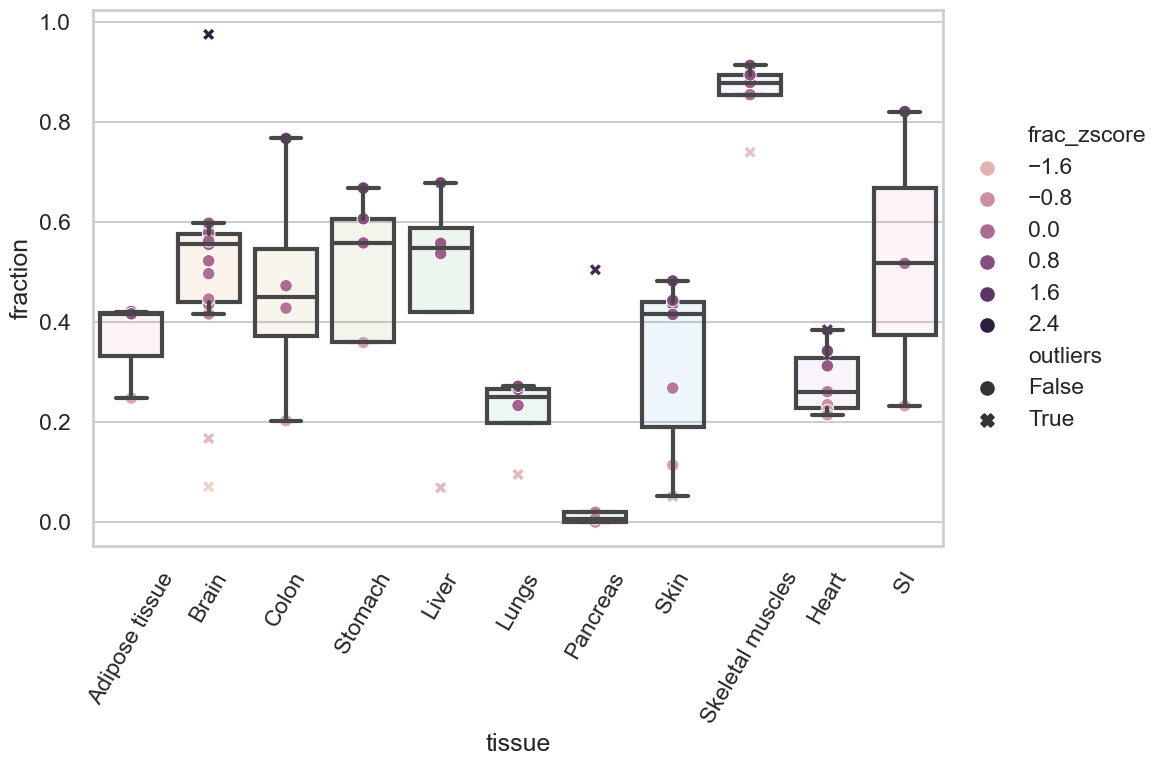

In [66]:
decon_data['frac_zscore'] = decon_data.groupby('tissue').fraction.transform(stats.zscore)
decon_data['outliers'] = decon_data.frac_zscore.map(np.abs) > 1.5
f = plt.figure()
f.set_size_inches(12,8)
ax= plt.gca()
sns.boxplot(data=decon_data, x='tissue', y='fraction', ax=ax, showfliers=False)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))
sns.scatterplot(data=decon_data, x='tissue', y='fraction', hue='frac_zscore', ax=ax, legend='brief', style='outliers')
plt.xticks(rotation=60);
ax.legend(bbox_to_anchor=(1.,0.5), loc='center left')
plt.tight_layout()
plt.savefig('{}/decon_outliers.png'.format(save_dir))

In [67]:
decon_immune_dict = {
    "Blood-B": "B cells",
    "Blood-T": "T cells",
    "Blood-NK": "NK cells",
    "Blood-Mono+Macro": "Non-granulocytes Myeloids",
    "Blood-Granul": "Granulocytes",
}
df_for_piv = decon_data.loc[
    ~decon_data.outliers, list(decon_immune_dict.keys()) + ["tissue", "fraction"]
].rename(columns=decon_immune_dict)
df_for_piv = np.maximum(
    decon_data.loc[~decon_data.outliers, list(decon_immune_dict.keys()) + ["fraction"]],
    0.0005,
)
df_for_piv = df_for_piv.join(decon_data.loc[~decon_data.outliers, ["tissue"]]).rename(
    columns=decon_immune_dict
)
decon_piv = df_for_piv.groupby("tissue").agg(gmean_w_nulls)
decon_piv = pd.concat([decon_piv, df_for_piv.groupby("tissue").agg(mult_unc_for_arr)])
decon_piv.index = pd.MultiIndex.from_product(
    [["mean", "unc"], decon_piv.index[: int(decon_piv.shape[0] / 2)]]
)
decon_piv["anchor_num"] = 0
decon_piv.loc["mean", "anchor_num"] = decon_piv.loc["mean", "anchor_num"].index.map(
    anchors_data.anchor_cell_number.to_dict()
)
unc_temp = err_add_to_mul(
    decon_piv.loc["mean", "anchor_num"].values,
    decon_piv.loc["unc", "anchor_num"].index.map(
        anchors_data.anchor_cell_unc.to_dict()
    ),
)
decon_piv.loc["unc", "anchor_num"] = unc_temp
decon_piv.index = decon_piv.index.set_levels(
    decon_piv.loc["mean"]
    .reset_index()
    .tissue.replace({"Skeletal muscles": "Skeletal Muscles"}),
    level=1,
)

In [68]:
im_ct = decon_immune_dict.values()
im_fracs_vals, im_fracs_unc = decon_piv.loc["mean", im_ct], decon_piv.loc["unc", im_ct]
anc_vals, anc_unc = (
    decon_piv.loc["mean", "anchor_num"],
    decon_piv.loc["unc", "anchor_num"],
)
anc_fracs, anc_fracs_unc = (
    decon_piv.loc["mean", "fraction"],
    decon_piv.loc["unc", "fraction"],
)

means = im_fracs_vals.mul(anc_vals / anc_fracs, axis=0)
unc = ((im_fracs_unc**2).add(anc_unc**2 + anc_fracs_unc**2, axis=0)) ** 0.5

In [69]:
conv_res = (
    means.reset_index()
    .melt(id_vars="tissue", var_name="cell_type", value_name="tot_decon")
    .set_index(["cell_type", "tissue"])
)
conv_res = conv_res.join(
    unc.reset_index()
    .melt(id_vars="tissue", var_name="cell_type", value_name="unc_decon")
    .set_index(["cell_type", "tissue"])
)
conv_res = conv_res.join(
    lymph_by_tiss.reset_index()
    .set_index(["cell_type", "tissue"])[["total_ext", "total_ext_err"]]
    .rename(columns={"total_ext": "tot_lit", "total_ext_err": "unc_lit"})
)


mac_to_add = tiss_agg_df[["total", "total_err"]].rename(
    columns={"total": "tot_lit", "total_err": "unc_lit"}
)
nm_to_add = (
    non_macro_piv.groupby("tissue")
    .apply(lambda df: agg_tissue_group_simple(df, cols=["Total_cells", "Uncertainty"]))
    .rename(columns={"Total_cells": "tot_lit", "Uncertainty": "unc_lit"})
)
myeloid_to_add = (
    pd.concat([mac_to_add, nm_to_add])
    .reset_index()
    .groupby("tissue")
    .apply(lambda df: agg_tissue_group_simple(df, cols=["tot_lit", "unc_lit"]))
)
myeloid_to_add.index = pd.MultiIndex.from_product(
    [["Non-granulocytes Myeloids"], myeloid_to_add.index]
)
conv_res.loc["Non-granulocytes Myeloids", ["tot_lit", "unc_lit"]] = myeloid_to_add


gran_to_add = (
    gran_by_tiss.reset_index()
    .groupby("tissue")
    .apply(lambda df: agg_tissue_group_simple(df, cols=["total_ext", "total_ext_err"]))
)
gran_to_add = gran_to_add.rename(columns={"total_ext": "tot_lit", "total_ext_err": "unc_lit"})
gran_to_add.index = pd.MultiIndex.from_product([["Granulocytes"], gran_to_add.index])

conv_res.loc["Granulocytes", ["tot_lit", "unc_lit"]] = gran_to_add
conv_res.head(2)

tot_decon  unc_decon       tot_lit   unc_lit
cell_type tissue                                                         
B cells   Adipose tissue  8.580196e+08   4.254998  1.291207e+07  2.603038
          Brain           5.991807e+08   2.185931  1.442427e+07  1.131014

Adding to a file concentrating all the comparison to be plotted

In [77]:
with pd.ExcelWriter(
    comp_fname,
    engine="openpyxl",
    if_sheet_exists="replace",
    mode="a",
) as writer:
    conv_res.to_excel(writer, sheet_name="Deconvolution")

## Combining multiplex data

Loading the data from Liu et al. and comparing the densities of cells in the lymphatic system with the aggregated estimates from the literature

In [71]:
cell_type_name_dic = {
    "B_cell": "B cells",
    "T_cell": "T cells",
    "NK_cell": "NK cells",
    "DC": "Dendritic cells",
}
tissue_name_dic = {
    "Lymph node": "Lymph nodes",
    "Tonsil": "Tonsils",
}


In [73]:
fname = f'{res_dir}/Liu_lymph_system_density.csv'
mul_dens_df = pd.read_csv(fname)
mul_dens_df['cell_type'] = mul_dens_df['Cell type'].replace(cell_type_name_dic)
mul_dens_df.tissue = mul_dens_df.tissue.replace(tissue_name_dic)
immune_cell_types = list(summ_immune.loc['Total_cells'].index.get_level_values(-1).unique())
mul_dens_df = mul_dens_df[mul_dens_df.cell_type.isin(immune_cell_types)]
mul_dens_df = mul_dens_df.set_index(['cell_type','tissue']).drop(columns=['Cell type'])


In [74]:
col_name_dict = {
    "ext_density": "density_lit",
    "ext_density_err": "unc_lit",
}
new_cols = list(set(col_name_dict.values()))
mul_dens_df = mul_dens_df.join(lymph_by_tiss.rename(columns=col_name_dict)[new_cols])

col_name_dict = {
    "density": "density_lit",
    "err": "unc_lit",
    "density_err": "unc_lit",
}

mac_to_add = tiss_agg_df.rename(columns=col_name_dict)[new_cols]
nm_to_add = non_macro_piv.rename(columns=col_name_dict)[new_cols]
mul_dens_df.loc["Macrophage", new_cols] = mac_to_add.loc[
    mul_dens_df.loc["Macrophage"].index, new_cols
].values
relevnat_tiss_for_DC = mul_dens_df.loc["Dendritic cells"].index[
    mul_dens_df.loc["Dendritic cells"].index.isin(
        nm_to_add.loc["Dendritic cells"].index
    )
]
relevant_inds = list(itertools.product(["Dendritic cells"], relevnat_tiss_for_DC))
mul_dens_df.loc[relevant_inds, new_cols] = nm_to_add.loc[relevant_inds]
mul_dens_df = mul_dens_df.reorder_levels((1, 0))

In [78]:
with pd.ExcelWriter(
    comp_fname,
    engine="openpyxl",
    if_sheet_exists="replace",
    mode="a",
) as writer:
    mul_dens_df.to_excel(writer, sheet_name="multiplex")

In [79]:
mul_dens_df['mass'] = mul_dens_df.index.get_level_values(0).map(tiss_agg_df.mass.to_dict())
mul_dens_df['total_mult'] = mul_dens_df.density * mul_dens_df.mass
mul_dens_df['total_lit'] = mul_dens_df.density_lit * mul_dens_df.mass

In [80]:
def geom_mean_weighted_by_unc(
    val1,
    unc_fac1,
    val2,
    unc_fac2,
):
    weights = np.vstack([1 / np.log(unc_fac1) ** 2, 1 / np.log(unc_fac2) ** 2]).T
    weights = weights / (weights.sum(axis=1)[:, None])
    gw_mean = val1 ** weights[:, 0] * val2 ** weights[:, 1]
    geom_var_intra = (
        np.log(unc_fac1) ** 2 * weights[:, 0] ** 2
        + np.log(unc_fac2) ** 2 * weights[:, 1] ** 2
    )
    geom_var_inter = (np.log(val1) - np.log(gw_mean)) ** 2 * weights[:, 0] ** 2 + (
        np.log(val2) - np.log(gw_mean)
    ) ** 2 * weights[:, 1] ** 2
    unc_fac = np.exp(np.sqrt(geom_var_intra + geom_var_inter))
    gw_mean[np.isnan(val2)] = val1[np.isnan(val2)]
    unc_fac[np.isnan(val2)] = unc_fac1[np.isnan(val2)]
    return np.vstack([gw_mean, unc_fac]).T

In [81]:
mul_dens_df["weighted_density"], mul_dens_df["weighted_unc"] = np.nan, np.nan
mul_dens_df[["weighted_density", "weighted_unc"]] = geom_mean_weighted_by_unc(
    mul_dens_df.density,
    mul_dens_df.unc_fac,
    mul_dens_df.density_lit,
    mul_dens_df.unc_lit,
)
mul_dens_df["weighted_total"] = mul_dens_df.weighted_density * mul_dens_df.mass

In [82]:
cols_dict = {'weighted_total':'Total_cells', 'weighted_unc':'Uncertainty'}
lymph_system_weighted = mul_dens_df.reset_index().groupby('cell_type').apply(lambda df: agg_tissue_group_simple(df, cols=list(cols_dict.keys())))
lymph_system_weighted =lymph_system_weighted.rename(columns=cols_dict)
lymph_system_weighted = lymph_system_weighted.reset_index().melt(id_vars='cell_type', value_name='Lymph system')
lymph_system_weighted['cell_type_family'] = lymph_system_weighted.cell_type.map(ctype_family_dict)
lymph_system_weighted = lymph_system_weighted.set_index(['variable', 'cell_type_family', 'cell_type'])

In [83]:
summ_immune.loc[lymph_system_weighted.index, 'Lymph system'] = lymph_system_weighted
summ_immune
# summ_immune = summ_immune.drop(columns='Total')

system                                                 Bone Marrow  \
variable    cell_type_family         cell_type                       
Total_cells Lymphocyte               T cells          2.149564e+10   
                                     B cells          1.438500e+10   
                                     Plasma cells     2.246322e+09   
                                     NK cells         3.302257e+09   
            Granulocyte              Eosinophil       2.898246e+10   
                                     Neutrophil       5.917975e+11   
                                     Mast cell        8.647883e+08   
                                     Basophil         1.509892e+09   
            Non-granulocytes Myeloid Monocyte         2.301045e+10   
                                     Macrophage       4.861421e+10   
                                     Dendritic cells           NaN   
Uncertainty Lymphocyte               T cells          1.993204e+00   
                                     B cells          1.941786e+00   
                                     Plasma cells     2.005355e+00   
                                     NK cells         2.157367e+00   
            Granulocyte              Eosinophil       1.628061e+00   
                                     Neutrophil       1.123818e+00   
                                     Mast cell        2.373958e+00   
                                     Basophil         2.425496e+00   
            Non-granulocytes Myeloid Monocyte         1.248524e+00   
                                     Macrophage       1.911018e+00   
                                     Dendritic cells           NaN   

system                                                       Blood  \
variable    cell_type_family         cell_type                       
Total_cells Lymphocyte               T cells          7.881499e+09   
                                     B cells          1.347500e+09   
                                     Plasma cells     1.869999e+07   
                                     NK cells         1.562006e+09   
            Granulocyte              Eosinophil       9.655568e+08   
                                     Neutrophil       2.205442e+10   
                                     Mast cell                 NaN   
                                     Basophil         1.906534e+08   
            Non-granulocytes Myeloid Monocyte         2.985576e+09   
                                     Macrophage                NaN   
                                     Dendritic cells  9.883943e+07   
Uncertainty Lymphocyte               T cells          1.000039e+00   
                                     B cells          1.000057e+00   
                                     Plasma cells     1.000140e+00   
                                     NK cells         1.000064e+00   
            Granulocyte              Eosinophil       1.211542e+00   
                                     Neutrophil       1.049494e+00   
                                     Mast cell                 NaN   
                                     Basophil         1.152823e+00   
            Non-granulocytes Myeloid Monocyte         1.163878e+00   
                                     Macrophage                NaN   
                                     Dendritic cells  2.241505e+00   

system                                                Lymph system  \
variable    cell_type_family         cell_type                       
Total_cells Lymphocyte               T cells          3.629113e+11   
                                     B cells          2.328213e+11   
                                     Plasma cells     1.230308e+09   
                                     NK cells         6.702239e+08   
            Granulocyte              Eosinophil       2.370233e+09   
                                     Neutrophil       4.603674e+10   
                                     Mast cell                 NaN   
        

In [84]:
melted_summ = (
    summ_immune.loc["Total_cells"]
    .reset_index(level=1)
    .melt(id_vars="cell_type", var_name="tissue", value_name="Total_cells")
)
melted_summ["Uncertainty"] = (
    summ_immune.loc["Uncertainty"]
    .reset_index(level=1)
    .melt(id_vars="cell_type", var_name="tissue", value_name="Uncertainty")[
        "Uncertainty"
    ]
)

total_by_cell_type = melted_summ.groupby("cell_type").apply(
    lambda df: agg_tissue_group_simple(df, cols=["Total_cells", "Uncertainty"])
)
total_by_tissue = melted_summ.groupby("tissue").apply(
    lambda df: agg_tissue_group_simple(df, cols=["Total_cells", "Uncertainty"])
)
total_by_both = agg_tissue_group_simple(melted_summ, cols=["Total_cells", "Uncertainty"])

C:\Users\Ron Sender\AppData\Local\Temp\ipykernel_7516\2147050369.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['unc_type'] = 'mul'


In [85]:
summ_immune.to_csv(f'{res_dir}/summary_immune_cells.csv')

In [86]:
set(mul_dens_df.index) - set(dens_df.set_index(['tissue','cell_type']).index)

{('Thymus', 'Dendritic cells'), ('Tonsils', 'Dendritic cells')}

In [87]:
temp_to_add = dens_df[
    dens_df.cell_type.eq("Macrophage") & dens_df.tissue.isin(["Thymus", "Tonsils"])
].copy()
temp_to_add.cell_type = "Dendritic cells"
dens_df = pd.concat([dens_df, temp_to_add], ignore_index=True)
dens_df = dens_df.set_index(["tissue", "cell_type"])
dens_df.loc[mul_dens_df.index, ["density", "err"]] = mul_dens_df[
    ["weighted_density", "weighted_unc"]
].values
dens_df.loc[mul_dens_df.index, "extrapolate"] = "multiplex"
dens_df = dens_df.reset_index()
dens_df

tissue        cell_type     mass            groups  \
0    Adipose tissue          B cells  14500.0    adipose tissue   
1    Adrenal glands          B cells     14.0  epithelial organ   
2             Blood          B cells   5500.0             blood   
3             Brain          B cells   1450.0               CNS   
4           Breasts          B cells     25.0  epithelial organ   
..              ...              ...      ...               ...   
427     Lymph nodes         Monocyte    225.0      lymph system   
428      Red marrow         Monocyte   1170.0            marrow   
429          Spleen         Monocyte    150.0      lymph system   
430          Thymus  Dendritic cells     20.0      lymph system   
431         Tonsils  Dendritic cells      3.0      lymph system   

    for_final_table    extrapolate       density       err  
0            Others          human  8.904878e+02  2.603038  
1            Others  extrapolation  4.743759e+05  2.321764  
2             Blood          human  2.449999e+05  1.000057  
3            Others          human  9.947774e+03  1.131014  
4            Others  extrapolation  4.743759e+05  2.321764  
..              ...            ...           ...       ...  
427    Lymph system          human  3.868471e+06  1.301464  
428     Bone Marrow          human  1.966705e+07  1.248524  
429    Lymph system          human  4.132965e+07  1.237011  
430    Lymph system      multiplex  2.681350e+06  1.779893  
431    Lymph system      multiplex  7.356780e+07  1.489476  

[432 rows x 8 columns]

In [ ]:
dens_df.to_csv(f'{res_dir}/density_by_ct_tiss.csv')